In [11]:
import sys
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, f1_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata


In [35]:
#Data on Microsoft
Msft_final = pd.read_csv('MicrosoftFinalData.csv', delimiter=',')
Msft_final.dataframeName = 'MicrosoftFinalData.csv'
Msft_news = pd.read_csv('MicrosoftNewsStock.csv', delimiter=',')
Msft_news.dataframeName = 'MicrosoftNewsStock.csv'

#Data on S&P500
SNP500_data = pd.read_csv('^GSPC.csv', delimiter=',')
SNP500_data.dataframeName = '^GSPC.csv'

#Data on DJI
DJI_data = pd.read_csv('^DJI.csv', delimiter=',')
DJI_data.dataframeName = '^DJI.csv'
DJI_news = pd.read_csv('Combined_News_DJIA.csv', delimiter=',')
DJI_news.dataframeName = 'Combined_News_DJIA.csv'

#Data on Apple
Appl_final = pd.read_csv('AppleFinalData.csv', delimiter=',')
Appl_final.dataframeName = 'AppleFinalData.csv'
Appl_news = pd.read_csv('AppleNewsStock.csv', delimiter=',')
Appl_news.dataframeName = 'AppleNewsStock.csv'

In [64]:
sid = SentimentIntensityAnalyzer()
neg, neu, pos, compound = [], [], [], []

def sentiment(df):
    for i in range(len(df)):
        sen = unicodedata.normalize('NFKD', train.iloc[i]['Top1','Top2','Top3','Top4'])
        ss = sid.polarity_scores(sen)
        neg.append(ss['neg'])
        neu.append(ss['neu'])
        pos.append(ss['pos'])
        compound.append(ss['compound'])
    df['neg'] = neg
    df['neu'] = neu
    df['pos'] = pos
    df['compound'] = compound

In [14]:
def if_news(column):
    if column == 0:
        return 0
    else:
        return 1

In [57]:
Msft_final['returns']=Msft_final['Close'].pct_change() 
Msft_final['if_news'] = Msft_final['compound'].apply(if_news)
df_weekly_Msft = Msft_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Msft['Date'] = pd.to_datetime(df_weekly_Msft['Date'])
df_weekly_Msft.set_index('Date',inplace=True)
df_weekly_Msft = df_weekly_Msft[1:]

Appl_final['returns']=Appl_final['Close'].pct_change() 
Appl_final['if_news'] = Appl_final['compound'].apply(if_news)
df_weekly_Appl = Appl_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Appl['Date'] = pd.to_datetime(df_weekly_Appl['Date'])
df_weekly_Appl.set_index('Date',inplace=True)
df_weekly_Appl = df_weekly_Appl[1:]

SNP500_data['returns'] = SNP500_data['Close'].pct_change()
SNP500_data['cum_returns']=SNP500_data['returns'].cumsum()
SNP500_data['Date'] = pd.to_datetime(SNP500_data['Date'])
DJI_data['returns'] = DJI_data['Close'].pct_change()
DJI_data['cum_returns']=DJI_data['returns'].cumsum()
DJI_data['Date'] = pd.to_datetime(DJI_data['Date'])

DJI_news['Date'] = pd.to_datetime(DJI_news['Date'])


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


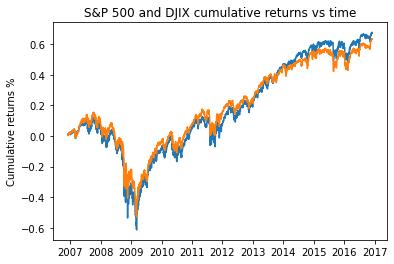

In [50]:
plt.figure()
plt.title('S&P 500 and DJIX cumulative returns vs time')
plt.ylabel('Cumulative returns %')
plt.plot(SNP500_data['Date'],SNP500_data['cum_returns'])
plt.plot(DJI_data['Date'],DJI_data['cum_returns'])
plt.show()

### Checking for class imbalance

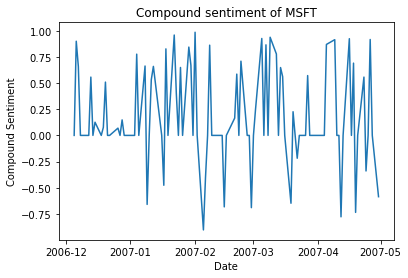

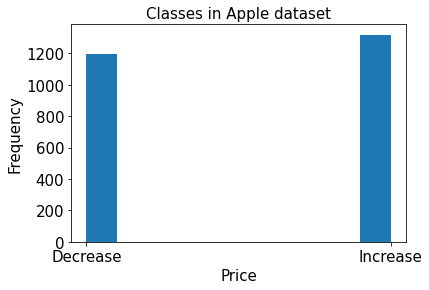

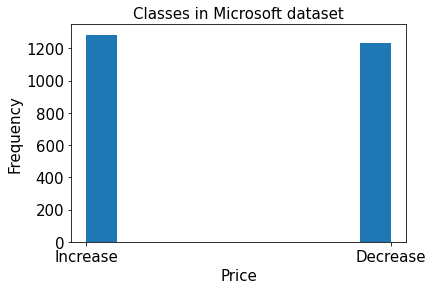

In [17]:
plt.figure(1)
plt.plot(df_weekly_Msft["compound"][1:100])
plt.xlabel("Date")
plt.ylabel("Compound Sentiment")
plt.title("Compound sentiment of MSFT")
plt.show()

df_weekly_Appl['class count'] = np.where(df_weekly_Appl['returns']>= 0,'Increase' , 'Decrease')
df_weekly_Msft['class count'] = np.where(df_weekly_Msft['returns']>= 0,'Increase' , 'Decrease')

plt.hist(df_weekly_Appl['class count'])
plt.title('Classes in Apple dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.hist(df_weekly_Msft['class count'])
plt.title('Classes in Microsoft dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Predicting stock from News using Decession Trees

In [18]:
def decision_tree_nlp(df,train_start,train_end,test_end,pos=0):
    
    train = (train_start <= df.index) & (df.index < train_end)
    test = (train_end <= df.index) & (df.index < test_end)

    if pos == 0:
        X_train = df[['compound']][train]
        y_train = df['returns'][train]

        X_test = df[['compound']][test]
        y_test = df['returns'][test]

    else:
        X_train = df[['compound','pos']][train]
        y_train = df['returns'][train]
        X_test = df[['compound','pos']][test]
        y_test = df['returns'][test]

        
    clf = tree.DecisionTreeRegressor()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    pred_cum = []
    real_cum = []
    
    for i in range(len(y_pred)):
        pred_cum.append(sum(y_pred[:i])+1)
        real_cum.append(sum(y_test[:i])+1)

    Accuracy = 1 - mean_squared_error(real_cum, pred_cum)    
    print("Accuracy score:",Accuracy*100,"%")
    
    plt.figure()
    plt.title('Cummulative returns')
    plt.plot(pred_cum,label = 'Predictions')
    plt.plot(real_cum,label = 'Actual')
    plt.legend()
    plt.show()
    
    return clf

Accuracy score: 97.6064102886844 %


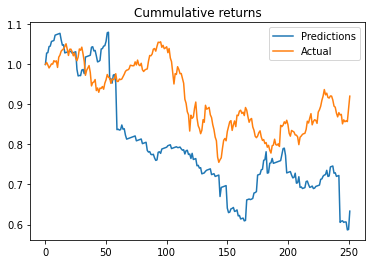

Accuracy score: 99.17080248411631 %


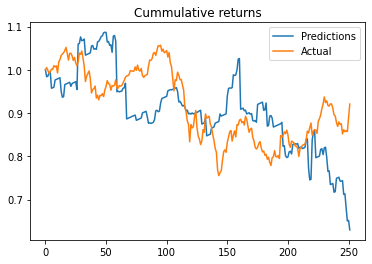

Accuracy score: 96.37635506735116 %


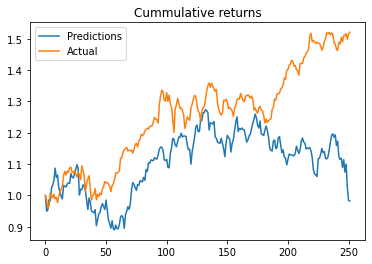

Accuracy score: 94.76522267964982 %


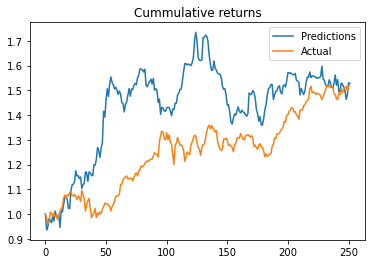

DecisionTreeRegressor()

In [19]:
decision_tree_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04')
decision_tree_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04',pos=1)
decision_tree_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04')
decision_tree_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04',pos=1)

### Predicting stock from News using Random Forest
 

In [67]:
def random_forest_nlp(df,train_start,train_end,test_end,pos=0):
    
    train = (train_start <= df.index) & (df.index < train_end)
    test = (train_end <= df.index) & (df.index < test_end)

    if pos == 0:
        X_train = df[['compound']][train]
        y_train = df['returns'][train]

        X_test = df[['compound']][test]
        y_test = df['returns'][test]

    elif pos == -1:
        X_train = df[['compound','neg']][train]
        y_train = df['returns'][train]
        X_test = df[['compound','neg']][test]
        y_test = df['returns'][test]
        
    else:
        X_train = df[['compound','pos']][train]
        y_train = df['returns'][train]
        X_test = df[['compound','pos']][test]
        y_test = df['returns'][test]

        
    regr = RandomForestRegressor(max_depth=None, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    pred_cum = []
    real_cum = []
    
    for i in range(len(y_pred)):
        pred_cum.append(sum(y_pred[:i])+1)
        real_cum.append(sum(y_test[:i])+1)

    Accuracy = 1 - mean_squared_error(real_cum, pred_cum)    
    print("Accuracy score:",Accuracy*100,"%")
    
    plt.figure()
    plt.title('Cummulative returns')
    plt.plot(pred_cum,label = 'Predictions')
    plt.plot(real_cum,label = 'Actual')
    plt.legend()
    plt.show()
    
    return regr

Accuracy score: 99.49152623861728 %


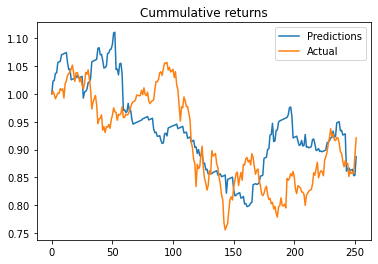

Accuracy score: 98.590030587783 %


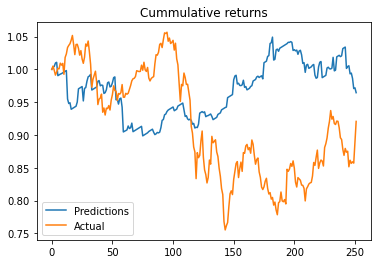

Accuracy score: 94.11064821077812 %


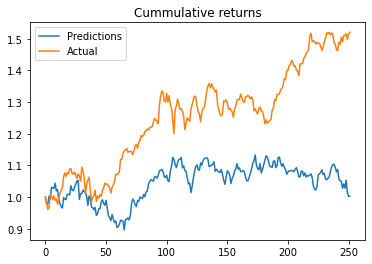

Accuracy score: 98.09178511751159 %


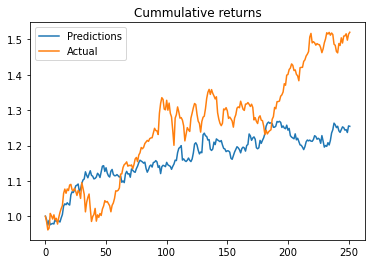

RandomForestRegressor(random_state=0)

In [68]:
random_forest_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04')
random_forest_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04',pos=1)
random_forest_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04')
random_forest_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04',pos=1)

In [60]:
DJI_news

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [65]:
sentiment(DJI_news)

KeyError: ('Top1', 'Top2', 'Top3', 'Top4')